---

## **Plotando Mapa de Relevo**

---

**OBJETIVO:** Aprender a plotar mapa de relevo para o Brasil, estado de Minas Gerais e Itajubá.

---

**DADOS DE ENTRADA:** São utilizados dados de relevo do GEBCO_2021 Grid e arquivos netcdf disponibilizados na pasta input.

1. Acessar o [site](https://download.gebco.net/) do dado de relevo
2. Selecionar a região de interesse
3. Escolher o formato **GeoTIFF** - Opção **Grid**
4. Clicar em **Add to basket**, seguido por **View basket** e em **Download your data**
4. Baixar a figura e inserir no drive na pasta input

---


**DADOS DE SAÍDA:** Figura
- **Tipo do dado:** Figura
- **Formato do dado:** arquivo JPEG
- **Imagens geradas:**
    1. Fig_1_mapa_relevo_brasil.jpeg
    2. Fig_2_mapa_relevo_mg.jpeg
    3. Fig_3_mapa_relevo_itajuba.jpeg
    4. Fig_4_mapa_relevo_regiao.jpeg


---

**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:

1.   **Instação** das bibliotecas
2.   **Importação** das biblotecas
3.   Montagem do **drive online**
4.   Define caminho do drive
5.   **Download** dos shapefiles
6.   Declaração de funções
7.   Plota relevo do Brasil
8.   Plota relevo de MG
9.   Plota relevo de Itajubá
10.  Plota relevo de uma região


---

**OBSERVAÇÕES IMPORTANTES**:
1. Mudar o caminho para o do seu drive.
2. Baixar o GIF do site da gebco e inserir na pasta input.

---

- **Realizado por:** Enrique V. Mattos e Raquel Gonçalves Pereira - 14/02/2022
- **Atualizado por:** Enrique V. Mattos - 19/06/2023


# **1° Passo:** Instalando as bibliotecas

In [ ]:
# Instalando o proplot (usado para gerar Mapas também)
!pip install -q proplot

# Instalando o cartopy (usado para gerar Mapas)
!pip uninstall shapely --yes
!pip install -q shapely cartopy --no-binary shapely --no-binary cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical

Chegando aqui, será necessário fazer a tediosa **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

In [2]:
# Instalando o Salem (usado para mascarar regiões)
!pip install -q rasterio
!pip install -q pyproj

# **2° Passo:** Importando bibliotecas

In [3]:
import numpy as np                          # Biblioteca para trabalhar com matrizes
import proplot as pplt                      # Biblioteca para gerar figuras
import os                                   # Biblioteca para acessar o sistema operacional
import cartopy.crs as ccrs                  # Biblioteca para trabalhar com projeções de mapas
import cartopy.io.shapereader as shpreader  # Biblioteca para ler arquivos shapefiles
import xarray as xr
import rasterio as rio                      # Biblioteca para trabalhar com arquivos raster
import pandas as pd
import matplotlib.pyplot as plt

# vamos ignorar vários avisos
import warnings
warnings.filterwarnings('ignore')

# **3° Passo:** Montando Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **4° Passo:** Caminho do diretório

In [5]:
# nome do diretório
dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/2_RELEVO/'

In [6]:
# cria a pasta de saídade com o nome "output"
import os
os.makedirs(f'{dir}output/', exist_ok=True)

# **5° Passo:** Download de informações auxiliares
 - Usaremos os shapefiles disponibilizados pelo IBGE no seguinte endereço: https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/

In [ ]:
# baixando o arquivo shapefile do Brasil
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
!unzip -o /content/br_unidades_da_federacao.zip
print('\n')

# baixando o arquivo shapefile do estado de MG
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/MG/mg_unidades_da_federacao.zip
!unzip -o /content/mg_unidades_da_federacao.zip
print('\n')

# baixando o arquivo shapefile dos munícipios de MG
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/MG/mg_municipios.zip
!unzip -o /content/mg_municipios.zip
print('\n')

# baixando o arquivo shapefile da cidade de Itajubá direto do GitHub "evmpython/shapefile/itajuba/"
!wget -O itajuba.shp https://github.com/evmpython/shapefile/blob/a5c80b5b82777d5b6cab891e7c123aba36e9505d/itajuba/itajuba.shp?raw=true
!wget -O itajuba.cpg https://github.com/evmpython/shapefile/blob/a5c80b5b82777d5b6cab891e7c123aba36e9505d/itajuba/itajuba.cpg?raw=true
!wget -O itajuba.dbf https://github.com/evmpython/shapefile/blob/a5c80b5b82777d5b6cab891e7c123aba36e9505d/itajuba/itajuba.dbf?raw=true
!wget -O itajuba.prj https://github.com/evmpython/shapefile/blob/a5c80b5b82777d5b6cab891e7c123aba36e9505d/itajuba/itajuba.prj?raw=true
!wget -O itajuba.shx https://github.com/evmpython/shapefile/blob/a5c80b5b82777d5b6cab891e7c123aba36e9505d/itajuba/itajuba.shx?raw=true
print('\n')

# **6° Passo:** Declarando funções

In [75]:
#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    import geopy
    from geopy import distance

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label, linestyle='--')

#-----------------------------------------------------------------------------------
# Função que plota os Estados
#-----------------------------------------------------------------------------------
def evm_plot_states(shapefile, cor, espessura_linha):

    """
    Retorna a plotagem dos contornos de um shapefile na figura

    Parâmetros de entrada:
                shapefile (shp): shapefile da regiao

    Parâmetros de saída:
                figura com o contorno da região baseado no shapefile fornecido
    """
    import cartopy.crs as ccrs
    import cartopy.io.shapereader as shpreader
    import matplotlib.pyplot as plt

    shapefile = list(shpreader.Reader(shapefile).geometries())
    ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor=cor,facecolor='none', linewidth=espessura_linha)

#-----------------------------------------------------------------------------------
# Função que plota as siglas
#-----------------------------------------------------------------------------------
def plot_siglas_statesb():

    color = 'gray'

    ax.annotate('RS', xy=(-54.0, -29.0),fontsize=15, color=color)
    ax.annotate('SC', xy=(-51.2, -27.5), fontsize=15, color=color)
    ax.annotate('PR', xy=(-52.0, -25.0), fontsize=15, color=color)
    ax.annotate('SP', xy=(-49.0, -22.5), fontsize=15, color=color)
    ax.annotate('MG', xy=(-45, -19.0), fontsize=15, color=color)
    ax.annotate('MS', xy=(-54.0, -21.0), fontsize=15, color=color)
    ax.annotate('Oceano Atlântico', xy=(-47.3, -26.0), fontsize=15, color=color)

#**PARTE 1:** Plota figura de relevo: Brasil

In [100]:
# leitura do arquivo
dset_brasil = xr.open_dataset(f'{dir}input/elevacao_brasil.nc')

In [101]:
# mostra os dados lidos
dset_brasil

<xarray.Dataset>
Dimensions:    (time: 1, y: 435, x: 503)
Coordinates:
  * time       (time) datetime64[ns] 2000-02-11
  * y          (y) float64 5.255 5.165 5.075 4.986 ... -33.55 -33.64 -33.73
  * x          (x) float64 -73.98 -73.89 -73.8 -73.71 ... -29.06 -28.97 -28.88
Data variables:
    elevation  (time, y, x) float64 ...
Attributes:
    transform:               [  0.08983153   0.         -74.02117941   0.    ...
    crs:                     +init=epsg:4326
    res:                     [0.08983153 0.08983153]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

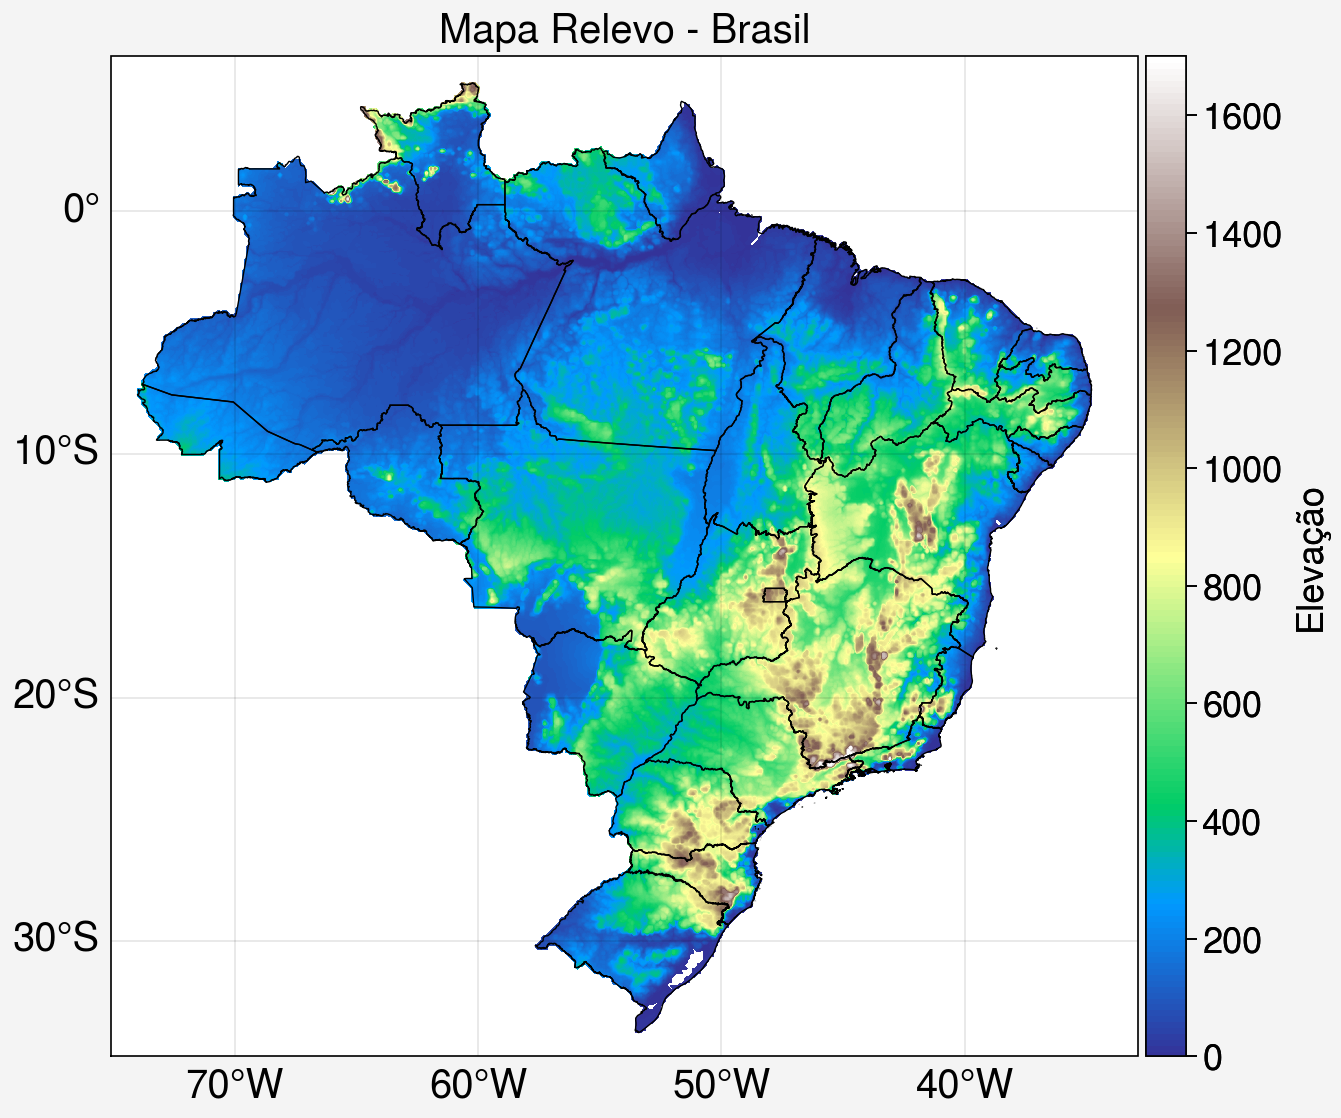

In [102]:
# moldura da figura
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

# mapa de contornos preenchidos
map1 = ax.contourf(dset_brasil['x'],
                   dset_brasil['y'],
                   dset_brasil['elevation'].squeeze(),
                   cmap='terrain',
                   levels=pplt.arange(0, 1700, 10))

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=True,
          latlines=10, lonlines=10,
          latlim=(float(dset_brasil['y'][0])+1.1, float(dset_brasil['y'][-1])-1.0),
          lonlim=(float(dset_brasil['x'][0])-1.1, float(dset_brasil['x'][-1])-4.0),
          title='Mapa Relevo - Brasil',
          small='20px', large='20px')

# plota shapefiles
evm_plot_states('/content/BR_UF_2019.shp', 'black', 0.5)

# barra de cores
fig.colorbar(map1, loc='r', label='Elevação', ticks=200, ticklabelsize=13, labelsize=13, space=0.3)

# salvar a figura
fig.save(f'{dir}output/Fig_1_mapa_relevo_brasil.png', dpi=300)

#**PARTE 2:** Plota figura de relevo: MG

In [103]:
# leitura do arquivo
dset_mg = xr.open_dataset(f'{dir}input/elevacao_mg.nc')

In [104]:
# mostra os dados lidos
dset_mg

<xarray.Dataset>
Dimensions:    (time: 1, y: 968, x: 1247)
Coordinates:
  * time       (time) datetime64[ns] 2000-02-11
  * y          (y) float64 -14.23 -14.24 -14.25 -14.26 ... -22.9 -22.91 -22.92
  * x          (x) float64 -51.05 -51.04 -51.03 -51.02 ... -39.87 -39.86 -39.85
Data variables:
    elevation  (time, y, x) float64 ...
Attributes:
    transform:               [ 8.98315284e-03  0.00000000e+00 -5.10512576e+01...
    crs:                     +init=epsg:4326
    res:                     [0.00898315 0.00898315]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

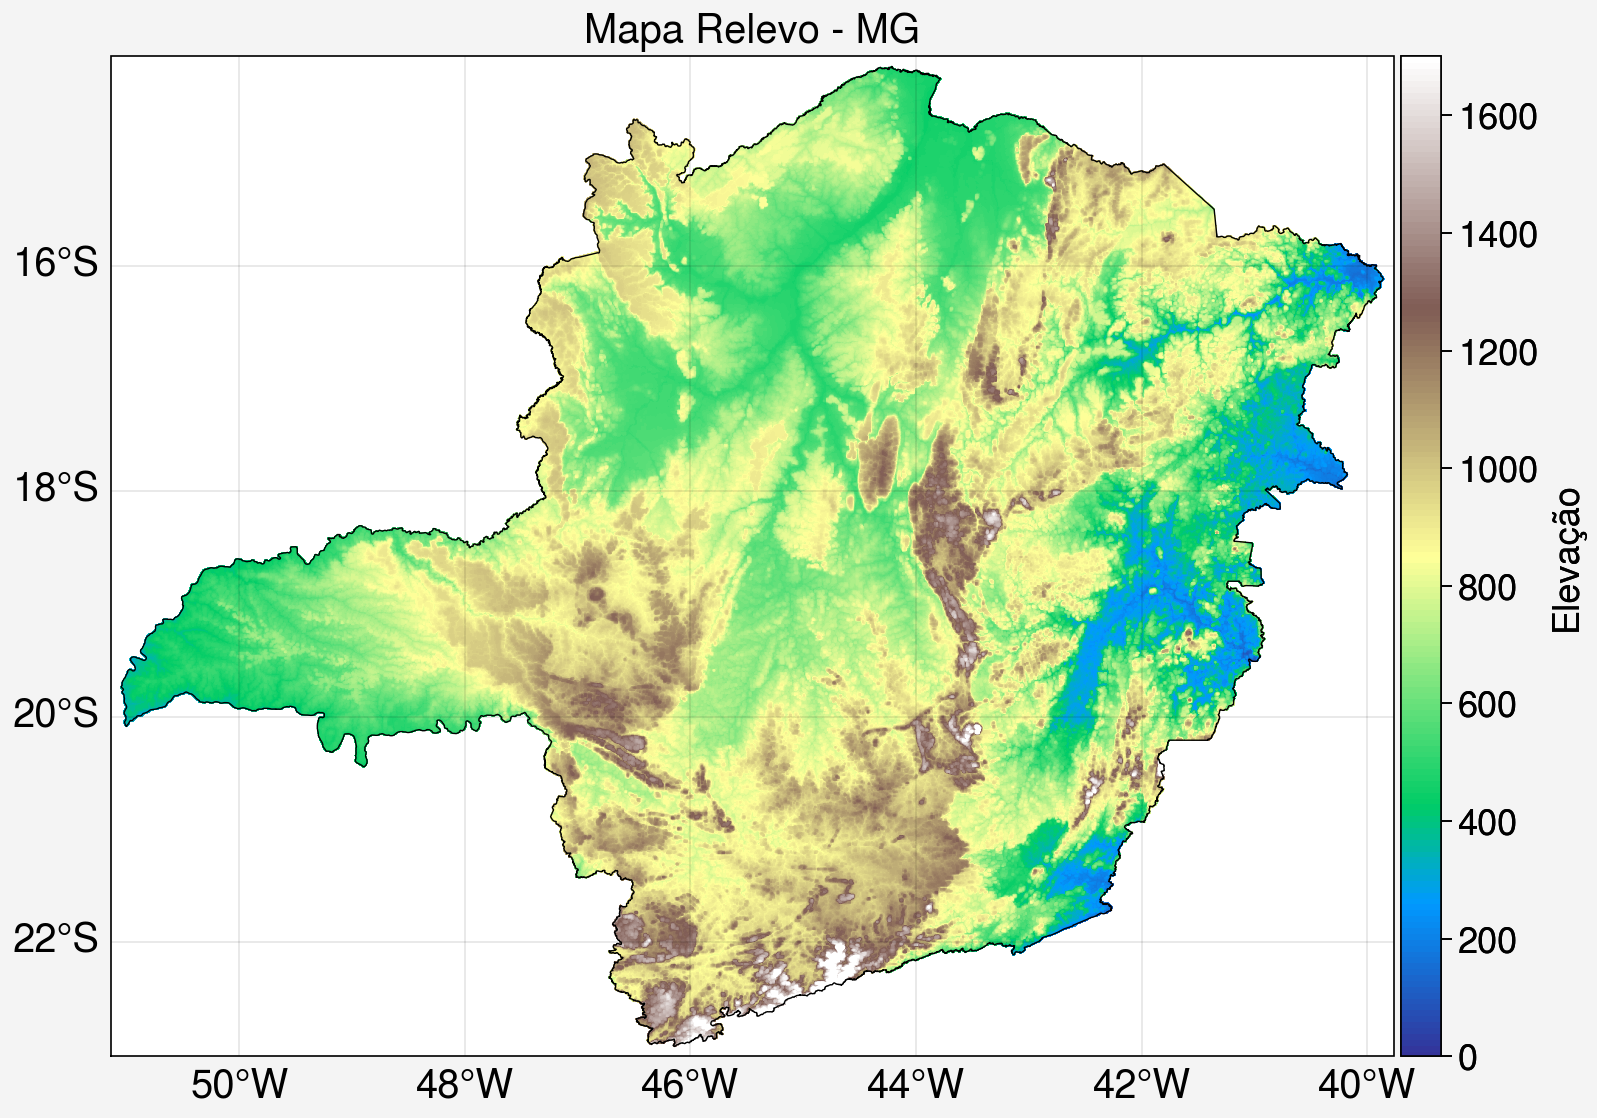

In [105]:
# moldura da figura
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

# mapa de contornos preenchidos
map1 = ax.contourf(dset_mg['x'],
                   dset_mg['y'],
                   dset_mg['elevation'][0,:,:],
                   cmap='terrain',
                   levels=pplt.arange(0, 1700, 10))

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=True,
          latlines=2, lonlines=2,
          latlim=(float(dset_mg['y'][0])+0.09, float(dset_mg['y'][-1])-0.09),
          lonlim=(float(dset_mg['x'][0])-0.09, float(dset_mg['x'][-1])+0.09),
          title='Mapa Relevo - MG',
          small='20px', large='20px')

# plota shapefiles
evm_plot_states('/content/MG_UF_2019.shp', 'black', 0.5)

# barra de cores
fig.colorbar(map1, loc='r', label='Elevação', ticks=200, ticklabelsize=13, labelsize=13, space=0.3)

# salvar a figura
fig.save(f'{dir}output/Fig_2_mapa_relevo_mg.jpeg', dpi=300)

#**PARTE 3:** Plota figura de relevo: Itajubá

In [106]:
# leitura do arquivo
dset_itajuba = xr.open_dataset(f'{dir}input/elevacao_itajuba.nc')

In [107]:
# mostra os dados lidos
dset_itajuba

<xarray.Dataset>
Dimensions:    (time: 1, y: 241, x: 333)
Coordinates:
  * time       (time) datetime64[ns] 2000-02-11
  * y          (y) float64 -22.34 -22.34 -22.34 -22.34 ... -22.53 -22.53 -22.53
  * x          (x) float64 -45.53 -45.53 -45.53 -45.53 ... -45.26 -45.26 -45.26
Data variables:
    elevation  (time, y, x) float64 ...
Attributes:
    transform:               [ 8.08483756e-04  0.00000000e+00 -4.55305712e+01...
    crs:                     +init=epsg:4326
    res:                     [0.00080848 0.00080848]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

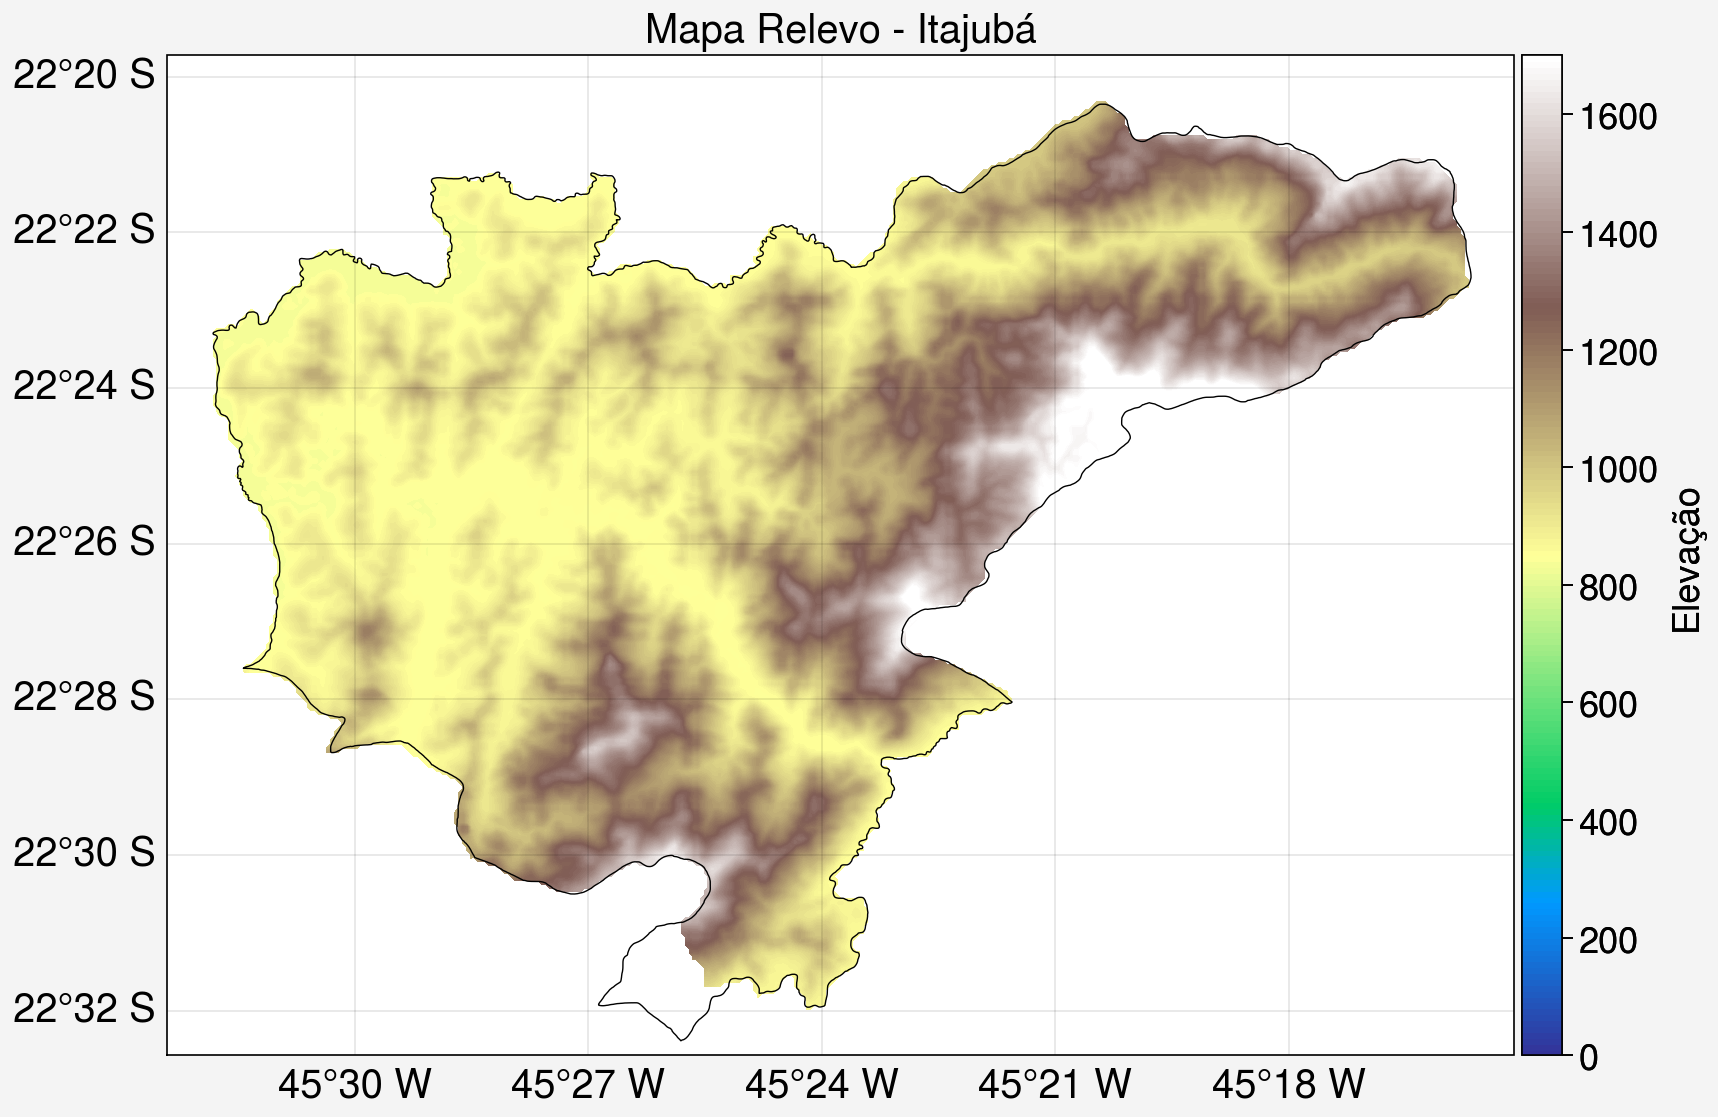

In [108]:
# moldura da figura # .salem.roi(shape=shp)
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

# mapa de contornos preenchidos
map1 = ax.contourf(dset_itajuba ['x'],
                   dset_itajuba['y'],
                   dset_itajuba['elevation'][0,:,:],
                   cmap='terrain',
                   levels=pplt.arange(0, 1700, 10))

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=True,
          latlim=(float(dset_itajuba['y'][0])+0.01, float(dset_itajuba ['y'][-1])-0.01),
          lonlim=(float(dset_itajuba['x'][0])-0.01, float(dset_itajuba ['x'][-1])+0.01),
          title='Mapa Relevo - Itajubá',
          small='20px', large='20px')

# plota shapefiles
evm_plot_states('/content/itajuba.shp', 'black', 0.5)

# barra de cores
fig.colorbar(map1, loc='r', label='Elevação', ticks=200, ticklabelsize=13, labelsize=13, space=0.3)

# salvar a figura
fig.save(f'{dir}output/Fig_3_mapa_relevo_itajuba .jpeg', dpi=300)

#**PARTE 4:** Plota figura de relevo: usando geotif

##**Lendo o arquivo**

In [109]:
# Abrindo arquivo tif. É bom abrir com with pq garante que o arquivo vai ser fechado
# Após a identação. Pode abrir diretamente com tif = rio.open('arq.tif')

filename = 'gebco_2021_n-15.0_s-30.0_w-55.0_e-40.0.tif'
with rio.open(f'{dir}input/{filename}') as tif:

    # Limites da imagem
    lonmin, latmin, lonmax, latmax = tif.bounds

    # Informações do arquivo no formato de dicionario dê um print(meta) para ver mais coisas
    meta = tif.meta

    # Resolução do arquivo
    res = tif.res

    #data = tif.indexes
    # Lê a matriz
    data = tif.read(1)

In [110]:
# metadados
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32767.0,
 'width': 3600,
 'height': 3600,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0041666666666666675, 0.0, -55.0,
        0.0, -0.0041666666666666675, -14.999999999999998)}

In [111]:
# elevações negativas substitui para "-32767.0"
data = np.where(data < 0, -32767.0, data)

# mascara dados que são "nodata"
data = np.ma.masked_equal(data, meta['nodata'])

In [112]:
# imprimindo na tela as latitudes, longitudes e resolução espacial do dado
print(lonmin, lonmax)
print(latmin, latmax)
print(res[0]*100*1000, res[1]*100*1000, 'metros')
print(data.min(), data.max())

-55.0 -40.0
-30.0 -14.999999999999998
416.66666666666674 416.66666666666674 metros
0.0 2762.0


In [113]:
data

masked_array(
  data=[[734.0, 698.0, 641.0, ..., 543.0, 447.0, 362.0],
        [748.0, 703.0, 663.0, ..., 542.0, 430.0, 380.0],
        [739.0, 723.0, 720.0, ..., 467.0, 382.0, 346.0],
        ...,
        [122.0, 111.0, 106.0, ..., --, --, --],
        [112.0, 106.0, 102.0, ..., --, --, --],
        [121.0, 112.0, 112.0, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=-32767.0)

## **Plota figura de relevo**

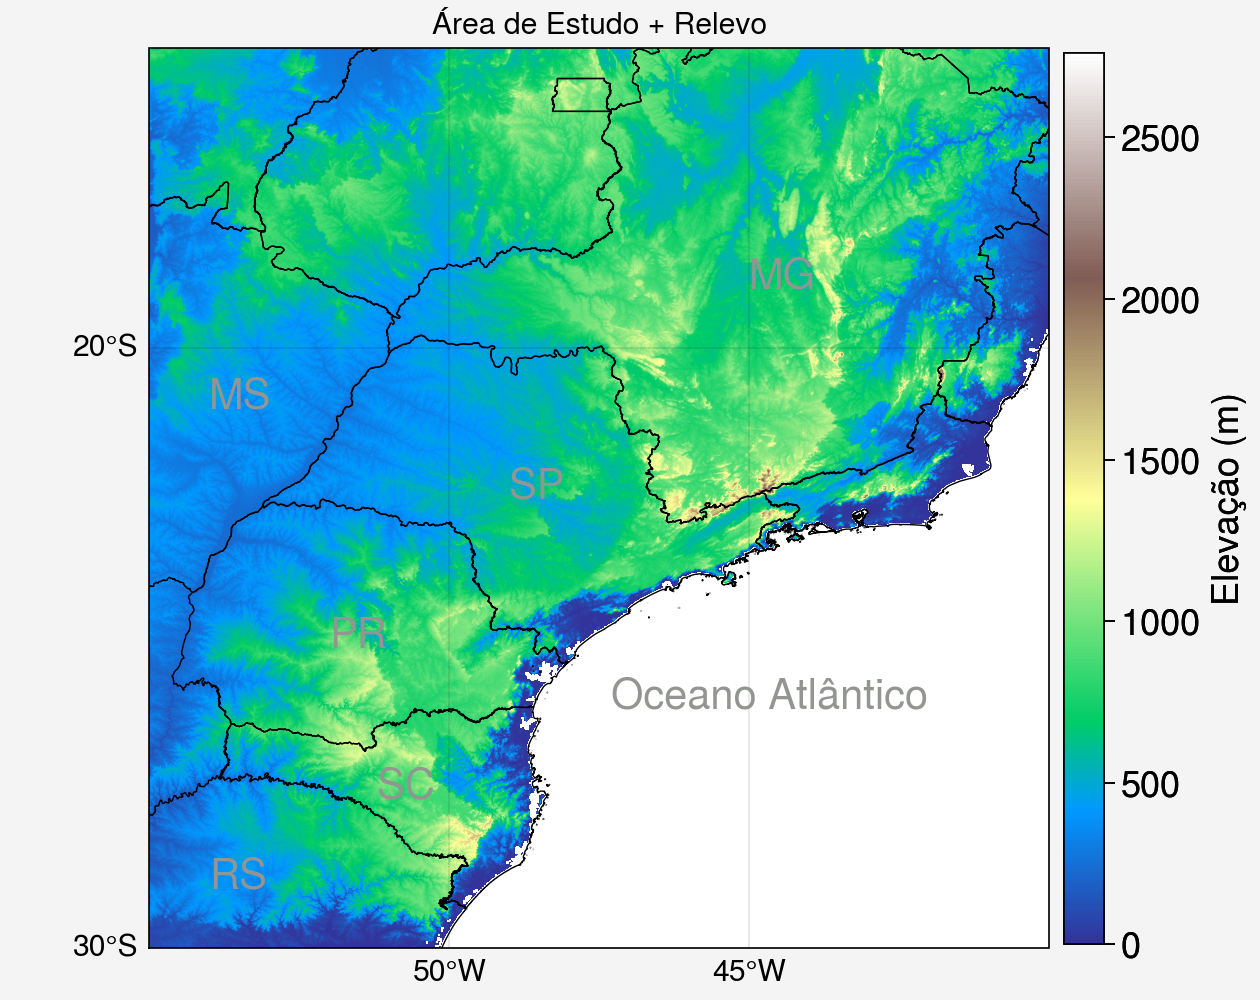

In [114]:
# moldura da figura
fig, ax = pplt.subplots(figsize=(6.3, 5), tight=True, proj='pcarree')

# formatação dos eixos da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=10, lonlines=5,
          latlim=(latmin, latmax),
          lonlim=(lonmin, lonmax),
          title=f'Área de Estudo + Relevo',
          small='15px',
          large='15px')

# plota figura
map1 = ax.imshow(data,
                 cmap='terrain',
                 vmin=0,
                 extent=[lonmin, lonmax, latmin, latmax])

# plota shapefiles
evm_plot_states('/content/BR_UF_2019.shp', 'black', 0.5)

# plota sigla dos estados
plot_siglas_statesb()

# plota barra de cores da figura
fig.colorbar(map1, loc='right', label='Elevação (m)', ticklabelsize=13, labelsize=13, space=-5.4, length=0.99)

# salvar a figura
fig.save(f'{dir}output/Fig_4_mapa_relevo_regiao .jpeg', dpi=300)